### Prepare the data

In [36]:
import pandas as pd

df = pd.read_hdf("filtered_data.hdf", "df1")
df = df[(df.type.isin(['item.click_long_bookwidget', 'page_view']))]
df.reset_index(inplace=True)

### Fetch item and category id information

In [22]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
%matplotlib inline

# Load the item ids from the dataset
df = pd.read_hdf("filtered_data.hdf", "df1")
df = df[(df.type == 'page_view')]
df['item_id'] = df.data.apply(lambda x: x.replace('/item/', ''))
df['item_id'] = df.item_id.apply(lambda x: x if x.isdigit() else None)
item_ids = [int(item_id) for item_id in df['item_id'] if item_id is not None]

# Connect to the database and fetch category information
connection = pymysql.connect(host='kidup-production.c5gkrouylqmw.eu-central-1.rds.amazonaws.com',
                             user='kidup_148161251',
                             password='knop0602R',
                             db='kidup',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

# One query for loading all item ids and category ids
df_item = pd.read_sql_query("select item.id as item_id, category.id as category_id, category.name as name from item inner join category on category.id = item.category_id where item.min_renting_days != 666", connection)
category_per_item = {}
category_labels = {}
for tuple in df_item.itertuples():
    category_per_item[tuple.item_id] = tuple.category_id
    category_labels[tuple.category_id] = tuple.name

### Calculate the percentage of page views given a click on the long booking widget button

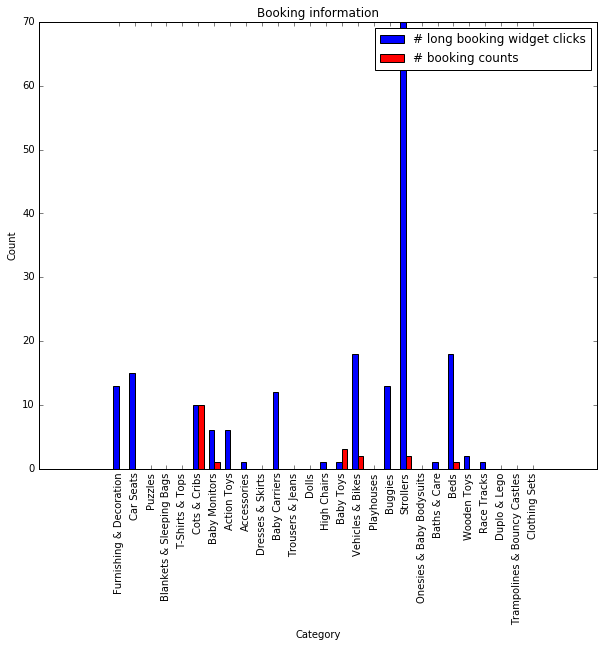

In [62]:
import json, re
from collections import defaultdict

counter = 0
click_counts = defaultdict(int)
booking_counts = defaultdict(int)

for category in category_labels.values():
    click_counts[category] = 0
    booking_counts[category] = 0

for tuple in df.itertuples():
    if tuple.type == 'item.click_long_bookwidget':
        item_id = int(tuple.data)
        if item_id in category_per_item:
            category_id = category_per_item[item_id]
            category_label = category_labels[category_id]
            click_counts[category_label] += 1
    if tuple.type == 'page_view':
        match = re.search(r'^[/]?item/(\d+)(.*)create-booking', tuple.data)
        if match is not None:
            item_id = match.group(1)
            if len(item_id) > 0:
                item_id = int(item_id)
                if item_id in category_per_item:
                    category_id = category_per_item[item_id]
                    category_label = category_labels[category_id]
                    booking_counts[category_label] += 1

# Make a plot of the counts
bar_width = 0.35
bar_activity = plt.bar(np.arange(len(click_counts)) - 0.5 * bar_width, click_counts.values(), bar_width, color='b', align='center', label='# long booking widget clicks')
bar_num_items = plt.bar(np.arange(len(click_counts)) + 0.5 * bar_width, booking_counts.values(), bar_width, color='r', align='center', label='# booking counts')
plt.xticks(range(len(click_counts)), click_counts.keys())
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.legend()
plt.title('Booking information')
plt.xlabel('Category')
plt.ylabel('Count')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 8)

plt.show()